In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn import impute

strokedata = pd.read_csv('healthcare-dataset-stroke-data.csv')
strokedata.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# EDA and Imputation

In [2]:
strokedata.shape[0]

5110

In [3]:
strokedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Since the BMI non-null count is 4909, which is less than the number of observations, this column has null values, and the other columns do not have null values.

In [4]:
strokedata.loc[strokedata['bmi'].isnull()].stroke.value_counts()

0    161
1     40
Name: stroke, dtype: int64

In [5]:
# Create a copy of the bmi column for imputation
strokedata['imputed_bmi'] = strokedata['bmi']
# Create a column that will say if bmi has been imputed or not
strokedata['bmi_original'] = 'no'

In [6]:
strokedata.loc[strokedata['bmi'].isnull(), 'bmi_original'] = 'yes'

In [7]:
strokedata.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,imputed_bmi,bmi_original
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,36.6,no
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,NaN,yes
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,32.5,no
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,34.4,no
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,24.0,no


In [8]:
strokedata['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

If we remove our BMI data, we lose about 1/6 of our overall data, so we will proceed to impute the data through KNN. First, we need to create a subset of the numeric columns and scale the data.

In [10]:
import sklearn as sk
from sklearn import preprocessing

#Considering numeric columns in the data to use KNN
num_cols = [2, 8, 12] # age and avg_glucose_level and imputed_bmi

#Create an object of type MinMaxScaler
scaler = sk.preprocessing.MinMaxScaler()

#Use the object method 'fit_transform' to scale the values to a standard uniform distribution
scaled_data = pd.DataFrame(scaler.fit_transform(strokedata.iloc[:,num_cols]))

In [11]:
scaled_data.head()

,0,1,2
0,0.816895,0.801265,0.301260
1,0.743652,0.679023,NaN
2,0.975586,0.234512,0.254296
3,0.597168,0.536008,0.276060
4,0.963379,0.549349,0.156930


In [12]:
#Imputing missing values with KNNImputer

#Define an object of type KNNImputer
imputer = impute.KNNImputer(n_neighbors=3, weights="uniform")

#Use the object method 'fit_transform' to impute missing values
imputed_arr = imputer.fit_transform(scaled_data)

#Scaling back the scaled array to obtain the data at the original scale

#Use the object method 'inverse_transform' to scale back the values to the original scale of the data
unscaled_data = scaler.inverse_transform(imputed_arr)

In [13]:
#Note the method imputes the missing value of all the columns
#However, we are interested in imputing the missing values of only the 'imputed_bmi' column

strokedata.loc[:,'imputed_bmi'] = unscaled_data[:,2]

In [14]:
# Check that we imputed the values

strokedata['imputed_bmi'].isnull().sum()

0

We successfully imputed the values of `bmi` using `age` and `avg_glucose_level` using KNN.

# Creating test and training data frame

In [15]:
np.random.seed(2)
train = strokedata.sample(round(strokedata.shape[0]*0.7))
test = strokedata.drop(train.index)

Train data consists of [3577 rows x 12 columns]  and test data consists of [1533 rows x 12 columns]

# Helper Function Creation 

In [16]:
#helper functions

#variable transformations
def var_transform(data):
    duration_binned = pd.qcut(train['duration'], 8, retbins = True)
    bins = duration_binned[1]
    data['duration_binned'] = pd.cut(data['duration'], bins = bins)
    return data

#jitter the values
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)

#Function to compute confusion matrix and prediction accuracy on training data
def confusion_matrix_train(model,cutoff=0.5):
    # Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))

#Function to compute confusion matrix and prediction accuracy on test data
#Function to compute confusion matrix and prediction accuracy on test data
def confusion_matrix_test(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))
    
#plotting roc
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    

from sklearn.metrics import precision_recall_curve
y = train.stroke # True response values
ypred = logit_model.predict(train) # predicted response values

p, r, thresholds = precision_recall_curve(y, ypred)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

# Examining the Distribution of the Target Column

In [17]:
train.stroke.value_counts()

0    3407
1     170
Name: stroke, dtype: int64

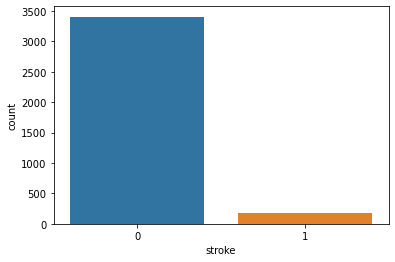

In [18]:
sns.countplot(x = 'stroke',data = train);

# Fitting the initial logistic regression model

Optimization terminated successfully.
         Current function value: 0.153034
         Iterations 9


<AxesSubplot:xlabel='age', ylabel='stroke'>

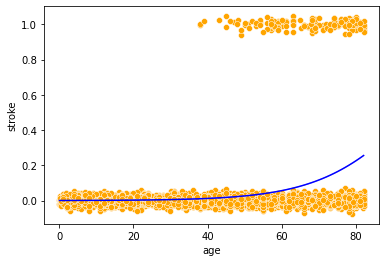

In [19]:
# Include jitter for better visualization of the distribution of 1s and 0s
def jitter(values,j=0):
    return values + np.random.normal(j,0.02,values.shape)

sns.scatterplot(x = jitter(train.age), y = jitter(train.stroke), data = train, color = 'orange')
logit_model = sm.logit(formula = 'stroke~age', data = train).fit()
sns.lineplot(x = 'age', y= logit_model.predict(train), data = train, color = 'blue')

In [20]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3577
Model:                          Logit   Df Residuals:                     3575
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Feb 2023   Pseudo R-squ.:                  0.1995
Time:                        11:18:37   Log-Likelihood:                -547.40
converged:                       True   LL-Null:                       -683.80
Covariance Type:            nonrobust   LLR p-value:                 2.803e-61
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.5734      0.429    -17.670      0.000      -8.413      -6.733
age            0.0793      0.006     12.711      0.000       0.067       0.092
==============================================================================
"""

In [21]:
(np.exp(0.0793)-1)*100

8.25290320710006

The coefficient of age is 0.0793, which means for a unit increase in age, the log odds of stroke likeliness increase by 0.0793, or the odds increases by 8.25%.

Assuming a significance level of $\alpha = 0.05$, age seems to be a staistically variable as its p-value and the model's overall LLR p-value are less than our $\alpha$ level.

Print out the correlations for each of the continuous variables to check for possible interactions.

In [22]:
corr_table = train.corr()
corr_table

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,imputed_bmi
id,1.000000,-0.014804,0.001437,0.005596,-0.029385,-0.003362,-0.004766,-0.007601
age,-0.014804,1.000000,0.272511,0.266071,0.226338,0.340309,0.248097,0.338419
hypertension,0.001437,0.272511,1.000000,0.108822,0.169636,0.171667,0.117325,0.166541
heart_disease,0.005596,0.266071,0.108822,1.000000,0.150224,0.049623,0.137965,0.049233
avg_glucose_level,-0.029385,0.226338,0.169636,0.150224,1.000000,0.178433,0.116067,0.182748
bmi,-0.003362,0.340309,0.171667,0.049623,0.178433,1.000000,0.046985,1.000000
stroke,-0.004766,0.248097,0.117325,0.137965,0.116067,0.046985,1.000000,0.044624
imputed_bmi,-0.007601,0.338419,0.166541,0.049233,0.182748,1.000000,0.044624,1.000000


BMI and age have a correlations of 0.340309 that might be worth looking into as an interaction term. To test this, train a basic model using all of the continuous variables and then add in the interaction term.

In [23]:
# basic model with all the continuous vars
logit_model = sm.logit(formula = 'stroke~bmi+avg_glucose_level+age', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.140173
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3441
Model:                          Logit   Df Residuals:                     3437
Method:                           MLE   Df Model:                            3
Date:                Tue, 28 Feb 2023   Pseudo R-squ.:                  0.2017
Time:                        11:18:37   Log-Likelihood:                -482.33
converged:                       True   LL-Null:                       -604.20
Covariance Type:            nonrobust   LLR p-value:                 1.478e-52
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -8.3364      0.663    -12.579      0.000      -9.635      -7.037
bmi                   0.0099      0.014      0.711      0.477      -0.017       0.037
avg_glucose_level     0.0047      0.002      3.061      0.002       0.002       0.008
age                   0.0761      0.007     11.156      0.000       0.063       0.089
=====================================================================================
"""

BMI does not appear to be statistically significant in this model, to test for the interaction, add an interaction term between BMI and age.

In [24]:
logit_model2 = sm.logit(formula = 'stroke~bmi+I(bmi*age)+avg_glucose_level+age', data = train).fit()
logit_model2.summary()

Optimization terminated successfully.
         Current function value: 0.139646
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3441
Model:                          Logit   Df Residuals:                     3436
Method:                           MLE   Df Model:                            4
Date:                Tue, 28 Feb 2023   Pseudo R-squ.:                  0.2047
Time:                        11:18:38   Log-Likelihood:                -480.52
converged:                       True   LL-Null:                       -604.20
Covariance Type:            nonrobust   LLR p-value:                 2.402e-52
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -11.0251      1.364     -8.082      0.000     -13.699      -8.351
bmi                   0.0970      0.039      2.501      0.012       0.021       0.173
I(bmi * age)         -0.0014      0.001     -2.238      0.025      -0.003      -0.000
avg_glucose_level     0.0049      0.002      3.237      0.001       0.002       0.008
age                   0.1192      0.021      5.704      0.000       0.078       0.160
=====================================================================================
"""

# Confusion matrices for Model #2

Classification accuracy = 95.2%
Precision = 29.5%
TPR or Recall = 8.9%
FNR = 91.1%
FPR = 0.9%
ROC-AUC = 84.9%


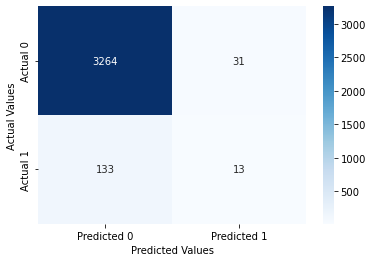

In [25]:
confusion_matrix_data(train.dropna(),train.dropna().stroke,logit_model2,cutoff=0.25)

Classification accuracy = 94.6%
Precision = 18.5%
TPR or Recall = 7.9%
FNR = 92.1%
FPR = 1.6%
ROC-AUC = 83.3%


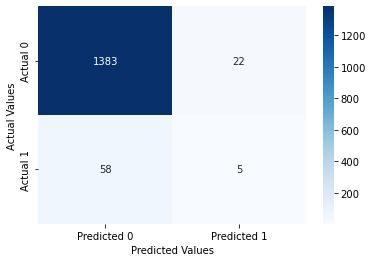

In [26]:
confusion_matrix_data(test.dropna(),test.dropna().stroke,logit_model2,cutoff=0.25)

Classification accuracy = 76.3%
Precision = 12.5%
TPR or Recall = 76.0%
FNR = 24.0%
FPR = 23.6%
ROC-AUC = 84.9%


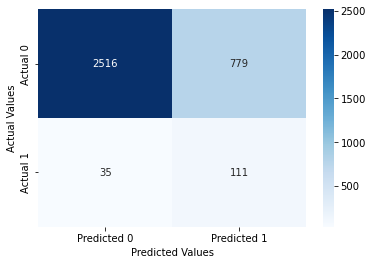

In [27]:
confusion_matrix_data(train.dropna(),train.dropna().stroke,logit_model2,cutoff=0.05)

Classification accuracy = 75.7%
Precision = 12.1%
TPR or Recall = 74.6%
FNR = 25.4%
FPR = 24.2%
ROC-AUC = 83.3%


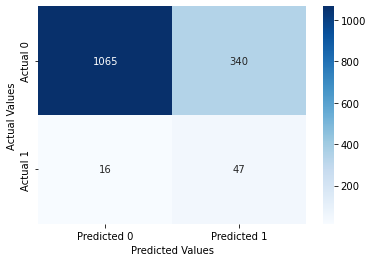

In [28]:
confusion_matrix_data(test.dropna(),test.dropna().stroke,logit_model2,cutoff=0.05)

By making the cutoff so low, we were able to increase our recall value in exchange for our precision. Because there are so few positive cases in our train data, even with a much higher cutoff, the precision was still low. The classification accuracy also fell a bit. 

# Since this model will be used for diagnosis, we must minimize FNR. 

In [29]:
logit_model3 = sm.logit(formula = 'stroke~bmi+I(bmi*age)+avg_glucose_level+age+hypertension', data = train).fit()
logit_model3.summary()

Optimization terminated successfully.
         Current function value: 0.138956
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3441
Model:                          Logit   Df Residuals:                     3435
Method:                           MLE   Df Model:                            5
Date:                Tue, 28 Feb 2023   Pseudo R-squ.:                  0.2086
Time:                        11:18:40   Log-Likelihood:                -478.15
converged:                       True   LL-Null:                       -604.20
Covariance Type:            nonrobust   LLR p-value:                 1.936e-52
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -10.7424      1.344     -7.995      0.000     -13.376      -8.109
bmi                   0.0904      0.038      2.374      0.018       0.016       0.165
I(bmi * age)         -0.0014      0.001     -2.177      0.029      -0.003      -0.000
avg_glucose_level     0.0045      0.002      2.947      0.003       0.002       0.008
age                   0.1153      0.021      5.597      0.000       0.075       0.156
hypertension          0.4667      0.209      2.233      0.026       0.057       0.876
=====================================================================================
"""

Classification accuracy = 94.1%
Precision = 18.9%
TPR or Recall = 11.1%
FNR = 88.9%
FPR = 2.1%
ROC-AUC = 83.9%


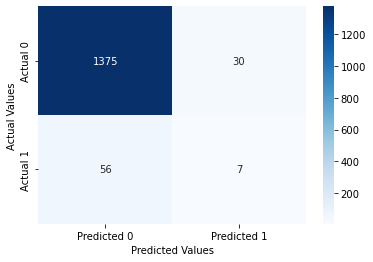

In [30]:
confusion_matrix_data(test.dropna(),test.dropna().stroke,logit_model3,cutoff=0.25)

Classification accuracy = 77.2%
Precision = 13.0%
TPR or Recall = 76.2%
FNR = 23.8%
FPR = 22.8%
ROC-AUC = 83.9%


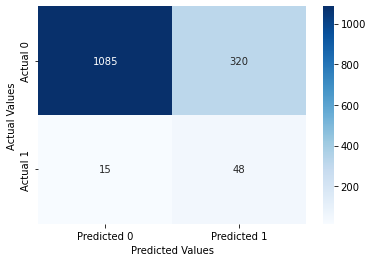

In [31]:
confusion_matrix_data(test.dropna(),test.dropna().stroke,logit_model3,cutoff=0.05)